<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Meta-Learning_Projects/blob/main/Optimization-Based/Few_shot_Learning_MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Implementation of model-agnostic meta-learning for Omniglot.***


In [30]:
import os
import glob

import google_drive_downloader as gdd
import imageio
import numpy as np
import torch
from torch.utils.data import dataset, sampler, dataloader
from torch import nn
import torch.nn.functional as F
from torch import autograd
import matplotlib.pyplot as plt
from torch.utils import tensorboard
#import pdb

NUM_TRAIN_CLASSES = 1100
NUM_VAL_CLASSES = 100
NUM_TEST_CLASSES = 423
NUM_SAMPLES_PER_CLASS = 20

NUM_INPUT_CHANNELS = 1
NUM_HIDDEN_CHANNELS = 64
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SUMMARY_INTERVAL = 10
SAVE_INTERVAL = 100
LOG_INTERVAL = 10
VAL_INTERVAL = LOG_INTERVAL * 5
NUM_TEST_TASKS = 600


In [17]:
BASE_PATH = './omniglot_resized'
GDD_FILE_ID = '1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI'
gdd.GoogleDriveDownloader.download_file_from_google_drive(
                file_id=GDD_FILE_ID,
                dest_path=f'{BASE_PATH}.zip',
                unzip=True
            )

In [18]:
def load_image(file_path):
    """Loads and transforms an Omniglot image.
    Args:
        file_path (str): file path of image
    Returns:
        a Tensor containing image data
            shape (1, 28, 28)
    """
    x = imageio.imread(file_path)
    x = torch.tensor(x, dtype=torch.float32).reshape([1, 28, 28])
    x = x / 255.0
    return 1 - x

In [19]:
class OmniglotDataset(dataset.Dataset):
    """Omniglot dataset for meta-learning.

    Each element of the dataset is a task. A task is specified with a key,
    which is a tuple of class indices (no particular order). The corresponding
    value is the instantiated task, which consists of sampled (image, label)
    pairs.
    """

    def __init__(self, num_support, num_query):
        """Inits OmniglotDataset.

        Args:
            num_support (int): number of support examples per class
            num_query (int): number of query examples per class
        """
        super().__init__()

        # get all character folders
        self._character_folders = glob.glob(
            os.path.join(BASE_PATH, '*/*/'))
        assert len(self._character_folders) == (
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )

        # shuffle characters
        np.random.default_rng(0).shuffle(self._character_folders)

        # check problem arguments
        assert num_support + num_query <= NUM_SAMPLES_PER_CLASS
        self._num_support = num_support
        self._num_query = num_query

    def __getitem__(self, class_idxs):
        """Constructs a task.

        Data for each class is sampled uniformly at random without replacement.
        The ordering of the labels corresponds to that of class_idxs.

        Args:
            class_idxs (tuple[int]): class indices that comprise the task

        Returns:
            images_support (Tensor): task support images
                shape (num_way * num_support, channels, height, width)
            labels_support (Tensor): task support labels
                shape (num_way * num_support,)
            images_query (Tensor): task query images
                shape (num_way * num_query, channels, height, width)
            labels_query (Tensor): task query labels
                shape (num_way * num_query,)
        """
        images_support, images_query = [], []
        labels_support, labels_query = [], []

        for label, class_idx in enumerate(class_idxs):
            # get a class's examples and sample from them
            all_file_paths = glob.glob(
                os.path.join(self._character_folders[class_idx], '*.png')
            )
            sampled_file_paths = np.random.default_rng().choice(
                all_file_paths,
                size=self._num_support + self._num_query,
                replace=False
            )
            images = [load_image(file_path) for file_path in sampled_file_paths]

            # split sampled examples into support and query
            images_support.extend(images[:self._num_support])
            images_query.extend(images[self._num_support:])
            labels_support.extend([label] * self._num_support)
            labels_query.extend([label] * self._num_query)

        # aggregate into tensors
        images_support = torch.stack(images_support)  # shape (N*S, C, H, W)
        labels_support = torch.tensor(labels_support)  # shape (N*S)
        images_query = torch.stack(images_query)
        labels_query = torch.tensor(labels_query)

        return images_support, labels_support, images_query, labels_query


In [20]:
class OmniglotSampler(sampler.Sampler):
    """Samples task specification keys for an OmniglotDataset."""

    def __init__(self, split_idxs, num_way, num_tasks):

      """Inits OmniglotSampler.

      Args:
          split_idxs (range): indices that comprise the
              training/validation/test split
          num_way (int): number of classes per task
          num_tasks (int): number of tasks to sample
      """
      super().__init__(None)

      self.split_idxs = split_idxs
      self.num_way = num_way
      self.num_tasks = num_tasks

    def __iter__(self):
      return (
          np.random.default_rng().choice(
              self.split_idxs,
              size=self.num_way,
              replace=False
          ) for _ in range(self.num_tasks)
      )

    def __len__(self):
        return self.num_tasks

In [21]:
def identity(x):
    return x

def get_omniglot_dataloader(
        split,
        batch_size,
        num_way,
        num_support,
        num_query,
        num_tasks_per_epoch
):
    """Returns a dataloader.DataLoader for Omniglot.

    Args:
        split (str): one of 'train', 'val', 'test'
        batch_size (int): number of tasks per batch
        num_way (int): number of classes per task
        num_support (int): number of support examples per class
        num_query (int): number of query examples per class
        num_tasks_per_epoch (int): number of tasks before DataLoader is
            exhausted
    """

    if split == 'train':
        split_idxs = range(NUM_TRAIN_CLASSES)
    elif split == 'val':
        split_idxs = range(
            NUM_TRAIN_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES
        )
    elif split == 'test':
        split_idxs = range(
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )
    else:
        raise ValueError

    return dataloader.DataLoader(
        dataset=OmniglotDataset(num_support, num_query),
        batch_size=batch_size,
        sampler=OmniglotSampler(split_idxs, num_way, num_tasks_per_epoch),
        num_workers=2,
        collate_fn=identity,
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )

In [22]:
image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")
image.shape

<ipython-input-22-913cf8e1afe4>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")


(28, 28)

In [23]:
samples = get_omniglot_dataloader(
        split='train',
        batch_size=1,
        num_way=4,
        num_support=1,
        num_query=1,
        num_tasks_per_epoch=1
)
tasks = next(iter(samples))
for task in tasks:
  images_support, labels_support, images_query, labels_query = task
images_support.shape, labels_support.shape, images_query.shape, labels_query.shape

<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


(torch.Size([4, 1, 28, 28]),
 torch.Size([4]),
 torch.Size([4, 1, 28, 28]),
 torch.Size([4]))

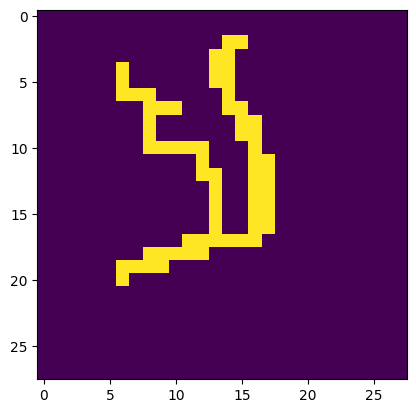

In [24]:
plt.imshow(images_support[0][0])

In [25]:
labels_support

tensor([0, 1, 2, 3])

In [26]:
def score(logits, labels):
    """Returns the mean accuracy of a model's predictions on a set of examples.

    Args:
        logits (torch.Tensor): model predicted logits
            shape (examples, classes)
        labels (torch.Tensor): classification labels from 0 to num_classes - 1
            shape (examples,)
    """

    #pdb.set_trace()
    assert logits.dim() == 2
    assert labels.dim() == 1
    assert logits.shape[0] == labels.shape[0]
    y = torch.argmax(logits, dim=-1) == labels
    y = y.type(torch.float)
    return torch.mean(y).item()

In [27]:
class MAML:
    """Trains and assesses a MAML."""

    def __init__(
            self,
            num_outputs,
            num_inner_steps,
            inner_lr,
            learn_inner_lrs,
            outer_lr,
            log_dir
    ):
        """Inits MAML.

        The network consists of four convolutional blocks followed by a linear
        head layer. Each convolutional block comprises a convolution layer, a
        batch normalization layer, and ReLU activation.

        Note that unlike conventional use, batch normalization is always done
        with batch statistics, regardless of whether we are training or
        evaluating. This technically makes meta-learning transductive, as
        opposed to inductive.

        Args:
            num_outputs (int): dimensionality of output, i.e. number of classes
                in a task
            num_inner_steps (int): number of inner-loop optimization steps
            inner_lr (float): learning rate for inner-loop optimization
                If learn_inner_lrs=True, inner_lr serves as the initialization
                of the learning rates.
            learn_inner_lrs (bool): whether to learn the above
            outer_lr (float): learning rate for outer-loop optimization
            log_dir (str): path to logging directory
        """
        meta_parameters = {}

        # construct feature extractor
        in_channels = NUM_INPUT_CHANNELS
        for i in range(NUM_CONV_LAYERS):
            meta_parameters[f'conv{i}'] = nn.init.xavier_uniform_(
                torch.empty(
                    NUM_HIDDEN_CHANNELS,
                    in_channels,
                    KERNEL_SIZE,
                    KERNEL_SIZE,
                    requires_grad=True,
                    device=DEVICE
                )
            )
            meta_parameters[f'b{i}'] = nn.init.zeros_(
                torch.empty(
                    NUM_HIDDEN_CHANNELS,
                    requires_grad=True,
                    device=DEVICE
                )
            )
            in_channels = NUM_HIDDEN_CHANNELS

        # construct linear head layer
        meta_parameters[f'w{NUM_CONV_LAYERS}'] = nn.init.xavier_uniform_(
            torch.empty(
                num_outputs,
                NUM_HIDDEN_CHANNELS,
                requires_grad=True,
                device=DEVICE
            )
        )
        meta_parameters[f'b{NUM_CONV_LAYERS}'] = nn.init.zeros_(
            torch.empty(
                num_outputs,
                requires_grad=True,
                device=DEVICE
            )
        )

        self._meta_parameters = meta_parameters
        self._num_inner_steps = num_inner_steps
        self._inner_lrs = {
            k: torch.tensor(inner_lr, requires_grad=learn_inner_lrs)
            for k in self._meta_parameters.keys()
        }
        self._outer_lr = outer_lr

        self._optimizer = torch.optim.Adam(
            list(self._meta_parameters.values()) +
            list(self._inner_lrs.values()),
            lr=self._outer_lr
        )
        self._log_dir = log_dir
        os.makedirs(self._log_dir, exist_ok=True)

        self._start_train_step = 0

    def _forward(self, images, parameters):
        """Computes predicted classification logits.

        Args:
            images (Tensor): batch of Omniglot images
                shape (num_images, channels, height, width)
            parameters (dict[str, Tensor]): parameters to use for
                the computation

        Returns:
            a Tensor consisting of a batch of logits
                shape (num_images, classes)
        """
        #pdb.set_trace()
        x = images
        for i in range(NUM_CONV_LAYERS):
            x = F.conv2d(
                input=x,
                weight=parameters[f'conv{i}'],
                bias=parameters[f'b{i}'],
                stride=1,
                padding='same'
            )
            x = F.batch_norm(x, None, None, training=True)
            x = F.relu(x)
        x = torch.mean(x, dim=[2, 3])
        return F.linear(
            input=x,
            weight=parameters[f'w{NUM_CONV_LAYERS}'],
            bias=parameters[f'b{NUM_CONV_LAYERS}']
        )

    def _inner_loop(self, images, labels, train):
        """Computes the adapted network parameters via the MAML inner loop.

        Args:
            images (Tensor): task support set inputs
                shape (num_images, channels, height, width)
            labels (Tensor): task support set outputs
                shape (num_images,)
            train (bool): whether we are training or evaluating (not necessary?)

        Returns:
            parameters (dict[str, Tensor]): adapted network parameters
            accuracies (list[float]): support set accuracy over the course of
                the inner loop, length num_inner_steps + 1
        """
        #pdb.set_trace()
        accuracies = []
        parameters = {
            k: torch.clone(v)
            for k, v in self._meta_parameters.items()
        }
        # This method computes the inner loop (adaptation) procedure for one
        # task. It also scores the model along the way.
        # Populate accuracies and update parameters.
        # F.cross_entropy to compute classification losses.
        # score() to compute accuracies.

        # here we are doing \phi_i = \theta - inner_lr * grad(\theta, L, D_{tr})
        for _ in range(self._num_inner_steps):
            logits = self._forward(images, parameters)
            loss = F.cross_entropy(logits, labels)

            # create graph due to computing second order derivatives in MAML
            gradients = autograd.grad(
                loss, parameters.values(), create_graph=True)

            # update parameters
            for i in range(len(parameters.keys())):
                k = list(parameters.keys())[i]
                v = list(parameters.values())[i]
                assert v.shape == gradients[i].shape, 'Not proper shape'

                parameters[k] = v - self._inner_lrs[k] * gradients[i]

            acc = score(logits, labels)
            accuracies.append(acc)

        final_logits = self._forward(images, parameters)
        final_acc = score(final_logits, labels)
        accuracies.append(final_acc)
        return parameters, accuracies

    def _outer_step(self, task_batch, train):
        """Computes the MAML loss and metrics on a batch of tasks.

        Args:
            task_batch (tuple): batch of tasks from an Omniglot DataLoader
            train (bool): whether we are training or evaluating

        Returns:
            outer_loss (Tensor): mean MAML loss over the batch, scalar
            accuracies_support (ndarray): support set accuracy over the
                course of the inner loop, averaged over the task batch
                shape (num_inner_steps + 1,)
            accuracy_query (float): query set accuracy of the adapted
                parameters, averaged over the task batch
        """
        #pdb.set_trace()
        outer_loss_batch = []
        accuracies_support_batch = []
        accuracy_query_batch = []
        for task in task_batch:
            images_support, labels_support, images_query, labels_query = task
            images_support = images_support.to(DEVICE)
            labels_support = labels_support.to(DEVICE)
            images_query = images_query.to(DEVICE)
            labels_query = labels_query.to(DEVICE)
            # For a given task, use the _inner_loop method to adapt, then
            # compute the MAML loss and other metrics.
            # F.cross_entropy to compute classification losses.
            # score() to compute accuracies.
            # Populate outer_loss_batch, accuracies_support_batch,
            # and accuracy_query_batch.

            # computes \phi_L
            parameters, supp_accs = self._inner_loop(
                images_support, labels_support, train)

            # gets the loss w.r.t. \phi_L
            logits = self._forward(images_query, parameters)
            loss = F.cross_entropy(logits, labels_query)
            outer_loss_batch.append(loss)

            accuracies_support_batch.append(supp_accs)
            q_accs = score(logits, labels_query)
            accuracy_query_batch.append(q_accs)

        outer_loss = torch.mean(torch.stack(outer_loss_batch))
        accuracies_support = np.mean(
            accuracies_support_batch,
            axis=0
        )
        accuracy_query = np.mean(accuracy_query_batch)
        return outer_loss, accuracies_support, accuracy_query


    def train(self, dataloader_train, dataloader_val, writer):
        """Train the MAML.

        Consumes dataloader_train to optimize MAML meta-parameters
        while periodically validating on dataloader_val, logging metrics, and
        saving checkpoints.

        Args:
            dataloader_train (DataLoader): loader for train tasks
            dataloader_val (DataLoader): loader for validation tasks
            writer (SummaryWriter): TensorBoard logger
        """
        print(f'Starting training at iteration {self._start_train_step}.')
        for i_step, task_batch in enumerate(
                dataloader_train,
                start=self._start_train_step
        ):
            self._optimizer.zero_grad()
            outer_loss, accuracies_support, accuracy_query = (
                self._outer_step(task_batch, train=True)
            )
            outer_loss.backward()
            self._optimizer.step()

            if i_step % LOG_INTERVAL == 0:
                print(
                    f'Iteration {i_step}: '
                    f'loss: {outer_loss.item():.3f}, '
                    f'pre-adaptation support accuracy: '
                    f'{accuracies_support[0]:.3f}, '
                    f'post-adaptation support accuracy: '
                    f'{accuracies_support[-1]:.3f}, '
                    f'post-adaptation query accuracy: '
                    f'{accuracy_query:.3f}'
                )
                writer.add_scalar('loss/train', outer_loss.item(), i_step)
                writer.add_scalar(
                    'train_accuracy/pre_adapt_support',
                    accuracies_support[0],
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/post_adapt_support',
                    accuracies_support[-1],
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/post_adapt_query',
                    accuracy_query,
                    i_step
                )

            if i_step % VAL_INTERVAL == 0:
                losses = []
                accuracies_pre_adapt_support = []
                accuracies_post_adapt_support = []
                accuracies_post_adapt_query = []
                for val_task_batch in dataloader_val:
                    outer_loss, accuracies_support, accuracy_query = (
                        self._outer_step(val_task_batch, train=False)
                    )
                    losses.append(outer_loss.item())
                    accuracies_pre_adapt_support.append(accuracies_support[0])
                    accuracies_post_adapt_support.append(
                        accuracies_support[-1])
                    accuracies_post_adapt_query.append(accuracy_query)
                loss = np.mean(losses)
                accuracy_pre_adapt_support = np.mean(
                    accuracies_pre_adapt_support
                )
                accuracy_post_adapt_support = np.mean(
                    accuracies_post_adapt_support
                )
                accuracy_post_adapt_query = np.mean(
                    accuracies_post_adapt_query
                )
                print(
                    f'Validation: '
                    f'loss: {loss:.3f}, '
                    f'pre-adaptation support accuracy: '
                    f'{accuracy_pre_adapt_support:.3f}, '
                    f'post-adaptation support accuracy: '
                    f'{accuracy_post_adapt_support:.3f}, '
                    f'post-adaptation query accuracy: '
                    f'{accuracy_post_adapt_query:.3f}'
                )
                writer.add_scalar('loss/val', loss, i_step)
                writer.add_scalar(
                    'val_accuracy/pre_adapt_support',
                    accuracy_pre_adapt_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/post_adapt_support',
                    accuracy_post_adapt_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/post_adapt_query',
                    accuracy_post_adapt_query,
                    i_step
                )

            if i_step % SAVE_INTERVAL == 0:
                self._save(i_step)

    def test(self, dataloader_test):
        """Evaluate the MAML on test tasks.

        Args:
            dataloader_test (DataLoader): loader for test tasks
        """
        accuracies = []
        for task_batch in dataloader_test:
            _, _, accuracy_query = self._outer_step(task_batch, train=False)
            accuracies.append(accuracy_query)
        mean = np.mean(accuracies)
        std = np.std(accuracies)
        mean_95_confidence_interval = 1.96 * std / np.sqrt(NUM_TEST_TASKS)
        print(
            f'Accuracy over {NUM_TEST_TASKS} test tasks: '
            f'mean {mean:.3f}, '
            f'95% confidence interval {mean_95_confidence_interval:.3f}'
        )

    def load(self, checkpoint_step):
        """Loads a checkpoint.

        Args:
            checkpoint_step (int): iteration of checkpoint to load

        Raises:
            ValueError: if checkpoint for checkpoint_step is not found
        """
        target_path = (
            f'{os.path.join(self._log_dir, "state")}'
            f'{checkpoint_step}.pt'
        )
        if os.path.isfile(target_path):
            state = torch.load(target_path)
            self._meta_parameters = state['meta_parameters']
            self._inner_lrs = state['inner_lrs']
            self._optimizer.load_state_dict(state['optimizer_state_dict'])
            self._start_train_step = checkpoint_step + 1
            print(f'Loaded checkpoint iteration {checkpoint_step}.')
        else:
            raise ValueError(
                f'No checkpoint for iteration {checkpoint_step} found.'
            )

    def _save(self, checkpoint_step):
        """Saves parameters and optimizer state_dict as a checkpoint.

        Args:
            checkpoint_step (int): iteration to label checkpoint with
        """
        optimizer_state_dict = self._optimizer.state_dict()
        torch.save(
            dict(meta_parameters=self._meta_parameters,
                 inner_lrs=self._inner_lrs,
                 optimizer_state_dict=optimizer_state_dict),
            f'{os.path.join(self._log_dir, "state")}{checkpoint_step}.pt'
        )
        print('Saved checkpoint.')


In [28]:

def main():
    num_way = 5
    num_support = 1
    num_query = 5
    num_inner_steps = 1
    inner_lr = 0.4
    learn_inner_lrs = False
    outer_lr = 0.001
    batch_size = 5
    checkpoint_step = -1
    test = False
    num_train_iterations = 15000

    log_dir = None
    if log_dir is None:
        log_dir = f'./logs/maml/omniglot.way:{num_way}.support:{num_support}.query:{num_query}.inner_steps:{num_inner_steps}.inner_lr:{inner_lr}.learn_inner_lrs:{learn_inner_lrs}.outer_lr:{outer_lr}.batch_size:{batch_size}'
    print(f'log_dir: {log_dir}')
    writer = tensorboard.SummaryWriter(log_dir=log_dir)

    maml = MAML(
        num_way,
        num_inner_steps,
        inner_lr,
        learn_inner_lrs,
        outer_lr,
        log_dir
    )

    if checkpoint_step > -1:
        maml.load(checkpoint_step)
    else:
        print('Checkpoint loading skipped.')

    if not test:
        num_training_tasks = batch_size * (num_train_iterations -
                                                checkpoint_step - 1)
        print(
            f'Training on {num_training_tasks} tasks with composition: '
            f'num_way={num_way}, '
            f'num_support={num_support}, '
            f'num_query={num_query}'
        )
        dataloader_train = get_omniglot_dataloader(
            'train',
            batch_size,
            num_way,
            num_support,
            num_query,
            num_training_tasks
        )
        dataloader_val = get_omniglot_dataloader(
            'val',
            batch_size,
            num_way,
            num_support,
            num_query,
            batch_size * 4
        )
        maml.train(
            dataloader_train,
            dataloader_val,
            writer
        )
    else:
        print(
            f'Testing on tasks with composition '
            f'num_way={num_way}, '
            f'num_support={num_support}, '
            f'num_query={num_query}'
        )
        dataloader_test = get_omniglot_dataloader(
            'test',
            1,
            num_way,
            num_support,
            num_query,
            NUM_TEST_TASKS
        )
        maml.test(dataloader_test)


In [ ]:
main()

log_dir: ./logs/maml/omniglot.way:5.support:1.query:5.inner_steps:1.inner_lr:0.4.learn_inner_lrs:False.outer_lr:0.001.batch_size:5
Checkpoint loading skipped.
Training on 75000 tasks with composition: num_way=5, num_support=1, num_query=5
Starting training at iteration 0.


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Iteration 0: loss: 1.457, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.600, post-adaptation query accuracy: 0.480


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 1.417, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.580, post-adaptation query accuracy: 0.448
Saved checkpoint.
Iteration 10: loss: 1.314, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.640, post-adaptation query accuracy: 0.552
Iteration 20: loss: 1.218, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 0.800, post-adaptation query accuracy: 0.648
Iteration 30: loss: 1.180, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.760, post-adaptation query accuracy: 0.536
Iteration 40: loss: 1.130, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.720, post-adaptation query accuracy: 0.552
Iteration 50: loss: 1.163, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.632


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 1.080, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.890, post-adaptation query accuracy: 0.680
Iteration 60: loss: 1.049, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.672
Iteration 70: loss: 1.174, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.616
Iteration 80: loss: 1.013, pre-adaptation support accuracy: 0.080, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.776
Iteration 90: loss: 0.978, pre-adaptation support accuracy: 0.360, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.776
Iteration 100: loss: 1.104, pre-adaptation support accuracy: 0.040, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.688


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 1.006, pre-adaptation support accuracy: 0.220, post-adaptation support accuracy: 0.950, post-adaptation query accuracy: 0.696
Saved checkpoint.
Iteration 110: loss: 1.035, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.608
Iteration 120: loss: 0.883, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.688
Iteration 130: loss: 1.074, pre-adaptation support accuracy: 0.080, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.712
Iteration 140: loss: 0.988, pre-adaptation support accuracy: 0.080, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.704
Iteration 150: loss: 0.985, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.640


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.895, pre-adaptation support accuracy: 0.190, post-adaptation support accuracy: 0.940, post-adaptation query accuracy: 0.732
Iteration 160: loss: 0.846, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.768
Iteration 170: loss: 0.886, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.728
Iteration 180: loss: 0.839, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.768
Iteration 190: loss: 0.726, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.744
Iteration 200: loss: 0.835, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.720


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.933, pre-adaptation support accuracy: 0.140, post-adaptation support accuracy: 0.990, post-adaptation query accuracy: 0.726
Saved checkpoint.
Iteration 210: loss: 0.927, pre-adaptation support accuracy: 0.320, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.704
Iteration 220: loss: 0.847, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.768
Iteration 230: loss: 0.769, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.776
Iteration 240: loss: 0.747, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.800
Iteration 250: loss: 0.854, pre-adaptation support accuracy: 0.080, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.736


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.836, pre-adaptation support accuracy: 0.220, post-adaptation support accuracy: 0.950, post-adaptation query accuracy: 0.726
Iteration 260: loss: 0.760, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.768
Iteration 270: loss: 0.845, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.744
Iteration 280: loss: 0.718, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.824
Iteration 290: loss: 0.678, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.824
Iteration 300: loss: 0.786, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.784


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.682, pre-adaptation support accuracy: 0.190, post-adaptation support accuracy: 0.970, post-adaptation query accuracy: 0.802
Saved checkpoint.
Iteration 310: loss: 0.719, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.744
Iteration 320: loss: 0.803, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.744
Iteration 330: loss: 0.687, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.768
Iteration 340: loss: 0.785, pre-adaptation support accuracy: 0.320, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.712
Iteration 350: loss: 0.738, pre-adaptation support accuracy: 0.320, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.800


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.731, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.782
Iteration 360: loss: 0.666, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.768
Iteration 370: loss: 0.566, pre-adaptation support accuracy: 0.320, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.880
Iteration 380: loss: 0.634, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.816
Iteration 390: loss: 0.756, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.696
Iteration 400: loss: 0.510, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.872


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.644, pre-adaptation support accuracy: 0.140, post-adaptation support accuracy: 0.990, post-adaptation query accuracy: 0.814
Saved checkpoint.
Iteration 410: loss: 0.545, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.880
Iteration 420: loss: 0.666, pre-adaptation support accuracy: 0.320, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.800
Iteration 430: loss: 0.626, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.840
Iteration 440: loss: 0.714, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.712
Iteration 450: loss: 0.634, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.808


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.626, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.990, post-adaptation query accuracy: 0.832
Iteration 460: loss: 0.594, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.808
Iteration 470: loss: 0.751, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.752
Iteration 480: loss: 0.540, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.824
Iteration 490: loss: 0.547, pre-adaptation support accuracy: 0.360, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.832
Iteration 500: loss: 0.533, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.840


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.661, pre-adaptation support accuracy: 0.190, post-adaptation support accuracy: 0.990, post-adaptation query accuracy: 0.800
Saved checkpoint.
Iteration 510: loss: 0.747, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.672
Iteration 520: loss: 0.616, pre-adaptation support accuracy: 0.080, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.864
Iteration 530: loss: 0.629, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.792
Iteration 540: loss: 0.677, pre-adaptation support accuracy: 0.080, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.760
Iteration 550: loss: 0.597, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.752


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.561, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.836
Iteration 560: loss: 0.745, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.720
Iteration 570: loss: 0.606, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.776
Iteration 580: loss: 0.702, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.832
Iteration 590: loss: 0.513, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.848
Iteration 600: loss: 0.565, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.816


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.561, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.990, post-adaptation query accuracy: 0.830
Saved checkpoint.
Iteration 610: loss: 0.632, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.800
Iteration 620: loss: 0.636, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.816
Iteration 630: loss: 0.400, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.888
Iteration 640: loss: 0.646, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.728
Iteration 650: loss: 0.577, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.792


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.503, pre-adaptation support accuracy: 0.230, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.858
Iteration 660: loss: 0.499, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.864
Iteration 670: loss: 0.571, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.800
Iteration 680: loss: 0.622, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.776
Iteration 690: loss: 0.570, pre-adaptation support accuracy: 0.360, post-adaptation support accuracy: 0.960, post-adaptation query accuracy: 0.768
Iteration 700: loss: 0.500, pre-adaptation support accuracy: 0.400, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.848


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.526, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.836
Saved checkpoint.
Iteration 710: loss: 0.473, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.864
Iteration 720: loss: 0.580, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.784
Iteration 730: loss: 0.492, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.888
Iteration 740: loss: 0.394, pre-adaptation support accuracy: 0.320, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.896
Iteration 750: loss: 0.495, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.816


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.487, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.868
Iteration 760: loss: 0.480, pre-adaptation support accuracy: 0.160, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.824
Iteration 770: loss: 0.503, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.856
Iteration 780: loss: 0.535, pre-adaptation support accuracy: 0.280, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.840
Iteration 790: loss: 0.608, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 0.920, post-adaptation query accuracy: 0.736
Iteration 800: loss: 0.484, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.832


<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-18-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.455, pre-adaptation support accuracy: 0.200, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.904
Saved checkpoint.
Iteration 810: loss: 0.537, pre-adaptation support accuracy: 0.120, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.832
Iteration 820: loss: 0.425, pre-adaptation support accuracy: 0.240, post-adaptation support accuracy: 1.000, post-adaptation query accuracy: 0.928
